In [2]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import jabble.dataset
import jabble.loss
import jabble.model

import matplotlib.pyplot as plt
from matplotlib import cm

<h1>33 - Fit multiple models to tellurics and stellar flux</h1>

In [56]:
from datetime import datetime
import os
date = datetime.today().strftime('%Y-%m-%d')
outdir = os.path.join('/scratch/mdd423/simulacra/out/',date)
os.makedirs(outdir,exist_ok=True)

In [3]:
import glob
files = glob.glob('/scratch/mdd423/simulacra/out/2022-03-07/data_rand_*l7.0e+038.6e+03*')
# import os
# mypath = '/scratch/mdd423/simulacra/out/2022-03-07/'
# files = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f)) and "8.3e+03" in f]

In [4]:
files

['/scratch/mdd423/simulacra/out/2022-03-07/data_rand_tell_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr10.0.h5',
 '/scratch/mdd423/simulacra/out/2022-03-07/data_rand_tell_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr100.0.h5',
 '/scratch/mdd423/simulacra/out/2022-03-07/data_rand_tell_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr250.0.h5',
 '/scratch/mdd423/simulacra/out/2022-03-07/data_rand_tell_e30_R130000.0_a10.0_p30.0_l7.0e+038.6e+03_snr50.0.h5']

In [5]:
import scipy.ndimage
def normalize(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low

In [6]:
datasets = []
h5_data = []
snrs = []
for file in files:
    data    = simulacra.dataset.from_h5(file)
    h5_data.append(data)
    epoches = data['data']['flux'].shape[0]

    wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
    flux = np.array(data['data']['flux'])
    ferr = np.array(data['data']['ferr'])

    masks = np.array(data['data']['mask'],dtype=bool)
    masks = np.logical_or(np.isnan(ferr), masks)
    masks = np.logical_or(np.isnan(flux), masks)
    masks = np.logical_or(flux <= 0, masks)

    sigma = 110
    dataset = jabble.dataset.Dataset.from_flux(wave,flux,ferr,masks,normalize,nargs=[sigma])
    dataset.set_mask(0.0,10.0)
    
    datasets.append(dataset)

    obs_times = data['data']['obs_times']
    times = at.Time(obs_times)

    loc    = data['parameters']['detector']['loc']
    target = data['parameters']['star']['target']
    resolution = float(data['parameters']['detector']['_resolution'][()])

    bc = target.radial_velocity_correction(obstime=times[-1],location=loc).to(u.km/u.s)
    rv = data['data']['rvs'].to(u.km/u.s)
    snr = np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])])
    snrs.append(snr)
    print(snr)

<HDF5 dataset "obs_times": shape (30,), type "|O">
9.987319089047359
<HDF5 dataset "obs_times": shape (30,), type "|O">
99.99862480486188
<HDF5 dataset "obs_times": shape (30,), type "|O">
249.9993002908167
<HDF5 dataset "obs_times": shape (30,), type "|O">
49.99733226186442


<h2>Load Data</h2>
Load in the datasets and normalize it using a gaussian filter. And take a look at slices of each dataset. Each dataset read in has a different average SNR across all epoches. We will fit a model to each dataset and compare the accuracy of the radial velocity as function of this SNR.

In [7]:
def normal_flux(y,sigma=100):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low

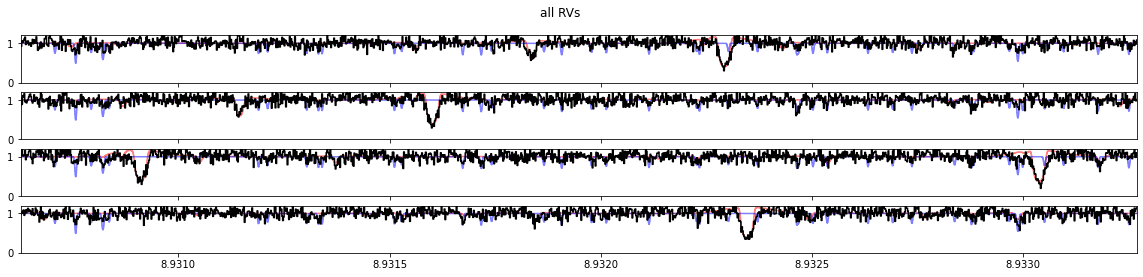

In [8]:
plt_inds = 4
xpmin = np.log(7560)
xpmax = np.log(7580)
fig, axes = plt.subplots(plt_inds,figsize=(20,4),sharex=True,sharey=True)

fig.suptitle('all RVs')
dataset_i = 0
for j in range(plt_inds):        
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[dataset_i]['theory']['interpolated']['star']['flux'][j,:])),'r',where='mid',alpha=0.5)
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(h5_data[dataset_i]['theory']['interpolated']['random']['flux'][j,:]),'b',where='mid',alpha=0.5)
    axes[j].step(np.log(h5_data[dataset_i]['data']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[dataset_i]['data']['flux'][j,:])),'k',where='mid')

    axes[j].set_xlim(xpmin,xpmax)
    axes[j].set_ylim(0.0,1.2)
plt.show() 

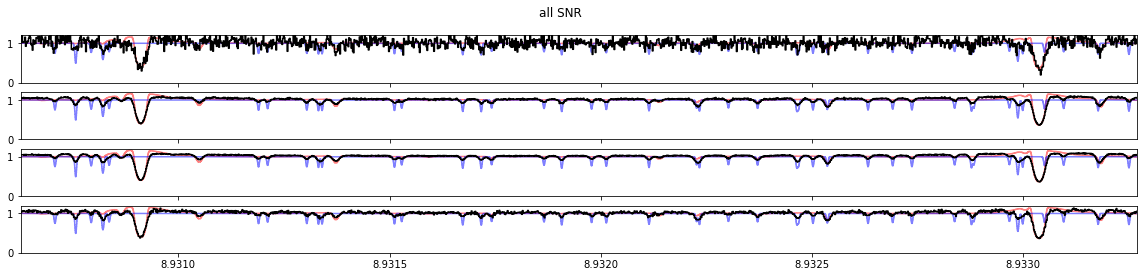

In [9]:
plt_i = 2
xpmin = np.log(7560)
xpmax = np.log(7580)
fig, axes = plt.subplots(plt_inds,figsize=(20,4),sharex=True,sharey=True)

fig.suptitle('all SNR')
for i in range(len(datasets)):       
    axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:])),'r',where='mid',alpha=0.5)
    axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]),'b',where='mid',alpha=0.5)
    axes[i].step(np.log(h5_data[i]['data']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[i]['data']['flux'][plt_i,:])),'k',where='mid')

    axes[i].set_xlim(xpmin,xpmax)
    axes[i].set_ylim(0.0,1.2)
plt.show()

<h2>Definitions</h2>
Define our loss function, Chi Square, Models, and Initial Values.

In [10]:
loss = jabble.loss.ChiSquare()
init_vels = np.linspace(-3000,3000,epoches) * u.km/u.s
init_shifts = jabble.dataset.shifts(init_vels)

In [11]:
vel_padding = 4 * u.km/u.s
x_grid = jabble.model.create_x_grid(dataset.xs,vel_padding,4*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))

models = [jabble.model.stellar_model(init_shifts,x_grid) + jabble.model.JaxLinear(x_grid) for dataset in datasets]

2022-03-08 18:51:06.884002: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-03-08 18:51:06.884030: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


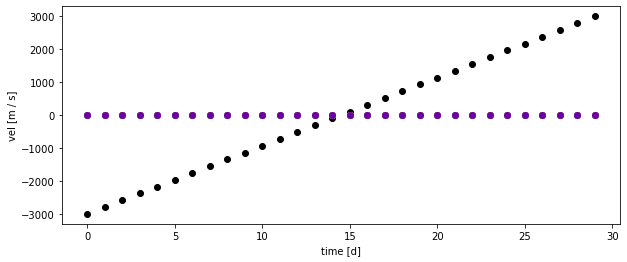

In [14]:
fig = plt.figure(figsize=(10,4))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='truth')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0][0].p)
    
    v_unit = u.m/u.s
    plt.plot((final_vels - init_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)))
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('time [d]')

plt.savefig('../out/velocity_plots.png')
plt.show()

In [13]:
models[0].display()

-AdditiveModel------------------------------------0
  0-CompositeModel-------------------------------------------------0
  0  0-ShiftingModel-----------------------------------------------0
  0  1-JaxLinear---------------------------------------------------0
  1-JaxLinear-------------------------------------0


In [20]:
def train_cycle(model,data,loss,fit1_inds,maxiter1):
    print('fitting round 1')
    model.fix()
    for ind in fit1_inds:
        model.fit(*ind)
    res1 = model.optimize(loss,data,maxiter1,verbose=True)
    model.fix()
    return model

def two_cycle(model,data,loss,fit1_inds,fit2_inds,maxiter1,maxiter2):
    model = train_cycle(model,data,loss,fit1_inds,maxiter1)
    model = train_cycle(model,data,loss,fit2_inds,maxiter2)
    return model

<h2>Round 1</h2>
Fit the flux control points to the data using the train cycle described!

In [21]:
ind1 = [[0,1],[1]]
iter1= 512
for i,model in enumerate(models):
    model = train_cycle(model,datasets[i],loss,ind1,iter1)

fitting round 1
[ Value: +5.32e+06 Grad: +2.89e+10 ]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       214114     M =           10


 This problem is unconstrained.


[ Value: +6.81e+06 Grad: +2.92e+13 ]
[ Value: +5.31e+06 Grad: +5.03e+10 ]
[ Value: +5.31e+06 Grad: +4.96e+10 ]
[ Value: +5.29e+06 Grad: +5.52e+10 ]
[ Value: +5.21e+06 Grad: +2.08e+11 ]
[ Value: +4.59e+06 Grad: +2.19e+12 ]
[ Value: +3.95e+06 Grad: +4.72e+11 ]
[ Value: +3.91e+06 Grad: +3.75e+10 ]
[ Value: +3.91e+06 Grad: +5.82e+09 ]
[ Value: +3.90e+06 Grad: +3.68e+09 ]
[ Value: +3.90e+06 Grad: +1.64e+10 ]
[ Value: +3.89e+06 Grad: +7.49e+10 ]
[ Value: +3.87e+06 Grad: +2.44e+11 ]
[ Value: +3.82e+06 Grad: +4.88e+11 ]
[ Value: +3.75e+06 Grad: +4.74e+11 ]
[ Value: +3.67e+06 Grad: +3.07e+10 ]
[ Value: +3.65e+06 Grad: +1.65e+10 ]
[ Value: +3.65e+06 Grad: +2.91e+10 ]
[ Value: +3.65e+06 Grad: +1.09e+11 ]
[ Value: +3.64e+06 Grad: +2.62e+10 ]
[ Value: +3.64e+06 Grad: +5.69e+09 ]
[ Value: +3.64e+06 Grad: +1.85e+08 ]
[ Value: +3.64e+06 Grad: +2.11e+08 ]
[ Value: +3.64e+06 Grad: +5.87e+08 ]
[ Value: +3.64e+06 Grad: +1.41e+09 ]
[ Value: +3.64e+06 Grad: +5.67e+09 ]
[ Value: +3.63e+06 Grad: +8.23e+09 ]
[

[ Value: +3.60e+06 Grad: +3.33e+06 ]
[ Value: +3.60e+06 Grad: +1.69e+06 ]
[ Value: +3.60e+06 Grad: +3.53e+06 ]
[ Value: +3.60e+06 Grad: +1.34e+07 ]
[ Value: +3.60e+06 Grad: +4.62e+07 ]
[ Value: +3.60e+06 Grad: +8.60e+07 ]
[ Value: +3.60e+06 Grad: +6.23e+07 ]
[ Value: +3.60e+06 Grad: +2.21e+09 ]
[ Value: +3.60e+06 Grad: +1.13e+08 ]
[ Value: +3.60e+06 Grad: +1.70e+07 ]
[ Value: +3.60e+06 Grad: +8.41e+06 ]
[ Value: +3.60e+06 Grad: +6.61e+07 ]
[ Value: +3.60e+06 Grad: +1.65e+06 ]
[ Value: +3.60e+06 Grad: +2.72e+06 ]
[ Value: +3.60e+06 Grad: +3.41e+06 ]
[ Value: +3.60e+06 Grad: +2.36e+08 ]
[ Value: +3.60e+06 Grad: +2.26e+07 ]
[ Value: +3.60e+06 Grad: +1.67e+07 ]
[ Value: +3.60e+06 Grad: +1.54e+07 ]
[ Value: +3.60e+06 Grad: +2.15e+07 ]
[ Value: +3.60e+06 Grad: +1.16e+07 ]
[ Value: +3.60e+06 Grad: +7.81e+07 ]
[ Value: +3.59e+06 Grad: +7.58e+06 ]
[ Value: +3.59e+06 Grad: +2.72e+06 ]
[ Value: +3.59e+06 Grad: +1.93e+07 ]
[ Value: +3.59e+06 Grad: +1.90e+08 ]
[ Value: +3.59e+06 Grad: +1.05e+08 ]
[


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


[ Value: +1.83e+08 Grad: +1.72e+14 ]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       214114     M =           10


 This problem is unconstrained.


[ Value: +2.11e+08 Grad: +7.33e+16 ]
[ Value: +1.82e+08 Grad: +1.75e+15 ]
[ Value: +1.80e+08 Grad: +1.72e+15 ]
[ Value: +1.72e+08 Grad: +1.74e+15 ]
[ Value: +1.47e+08 Grad: +4.61e+15 ]
[ Value: +6.45e+07 Grad: +9.55e+15 ]
[ Value: +5.93e+07 Grad: +7.06e+15 ]
[ Value: +5.49e+07 Grad: +2.97e+13 ]
[ Value: +5.48e+07 Grad: +2.71e+13 ]
[ Value: +5.47e+07 Grad: +3.01e+13 ]
[ Value: +5.42e+07 Grad: +7.35e+13 ]
[ Value: +5.10e+07 Grad: +6.38e+14 ]
[ Value: +4.68e+07 Grad: +1.25e+15 ]
[ Value: +4.17e+07 Grad: +9.79e+14 ]
[ Value: +3.85e+07 Grad: +1.68e+14 ]
[ Value: +3.74e+07 Grad: +3.60e+13 ]
[ Value: +3.71e+07 Grad: +1.04e+14 ]
[ Value: +3.64e+07 Grad: +2.55e+14 ]
[ Value: +3.54e+07 Grad: +4.17e+14 ]
[ Value: +4.05e+07 Grad: +9.32e+15 ]
[ Value: +3.51e+07 Grad: +2.95e+14 ]
[ Value: +3.45e+07 Grad: +5.46e+13 ]
[ Value: +3.43e+07 Grad: +8.65e+12 ]
[ Value: +3.43e+07 Grad: +1.47e+14 ]
[ Value: +3.42e+07 Grad: +4.17e+12 ]
[ Value: +3.42e+07 Grad: +3.14e+12 ]
[ Value: +3.42e+07 Grad: +2.78e+12 ]
[

[ Value: +3.10e+07 Grad: +4.19e+10 ]
[ Value: +3.10e+07 Grad: +9.81e+09 ]
[ Value: +3.10e+07 Grad: +1.83e+10 ]
[ Value: +3.10e+07 Grad: +1.81e+11 ]
[ Value: +3.10e+07 Grad: +1.00e+11 ]
[ Value: +3.10e+07 Grad: +7.15e+10 ]
[ Value: +3.10e+07 Grad: +4.14e+10 ]
[ Value: +3.10e+07 Grad: +1.04e+12 ]
[ Value: +3.10e+07 Grad: +9.08e+10 ]
[ Value: +3.10e+07 Grad: +1.47e+10 ]
[ Value: +3.10e+07 Grad: +4.25e+09 ]
[ Value: +3.10e+07 Grad: +2.19e+10 ]
[ Value: +3.10e+07 Grad: +1.28e+10 ]
[ Value: +3.10e+07 Grad: +5.40e+11 ]
[ Value: +3.10e+07 Grad: +6.26e+10 ]
[ Value: +3.10e+07 Grad: +3.32e+09 ]
[ Value: +3.10e+07 Grad: +2.46e+10 ]
[ Value: +3.10e+07 Grad: +5.48e+10 ]
[ Value: +3.10e+07 Grad: +5.10e+11 ]
[ Value: +3.10e+07 Grad: +2.07e+11 ]
[ Value: +3.09e+07 Grad: +9.46e+10 ]
[ Value: +3.09e+07 Grad: +4.38e+09 ]
[ Value: +3.09e+07 Grad: +9.70e+10 ]
[ Value: +3.09e+07 Grad: +1.03e+12 ]
[ Value: +3.09e+07 Grad: +2.00e+11 ]
[ Value: +3.09e+07 Grad: +1.19e+11 ]
[ Value: +3.09e+07 Grad: +2.15e+10 ]
[

[ Value: +3.09e+07 Grad: +8.02e+09 ]
[ Value: +3.09e+07 Grad: +3.81e+09 ]
[ Value: +3.09e+07 Grad: +2.90e+09 ]
[ Value: +3.09e+07 Grad: +8.89e+09 ]
[ Value: +3.09e+07 Grad: +2.05e+11 ]
[ Value: +3.09e+07 Grad: +3.45e+10 ]
[ Value: +3.09e+07 Grad: +8.42e+09 ]
[ Value: +3.09e+07 Grad: +4.11e+09 ]
[ Value: +3.09e+07 Grad: +1.15e+11 ]
[ Value: +3.09e+07 Grad: +4.85e+09 ]
[ Value: +3.09e+07 Grad: +2.84e+09 ]
[ Value: +3.09e+07 Grad: +4.01e+09 ]
[ Value: +3.09e+07 Grad: +1.74e+10 ]
[ Value: +3.09e+07 Grad: +4.84e+10 ]
[ Value: +3.09e+07 Grad: +1.04e+11 ]
[ Value: +3.09e+07 Grad: +6.32e+10 ]
[ Value: +3.09e+07 Grad: +6.52e+11 ]
[ Value: +3.09e+07 Grad: +1.89e+11 ]
[ Value: +3.09e+07 Grad: +1.10e+10 ]
[ Value: +3.09e+07 Grad: +3.22e+09 ]
[ Value: +3.09e+07 Grad: +2.91e+09 ]
[ Value: +3.09e+07 Grad: +1.33e+13 ]
[ Value: +3.09e+07 Grad: +1.22e+10 ]
[ Value: +3.09e+07 Grad: +9.37e+09 ]
[ Value: +3.09e+07 Grad: +1.59e+10 ]
[ Value: +3.09e+07 Grad: +9.62e+08 ]
[ Value: +3.09e+07 Grad: +3.12e+09 ]
[

 This problem is unconstrained.


[ Value: +1.29e+09 Grad: +2.79e+18 ]
[ Value: +1.12e+09 Grad: +7.02e+16 ]
[ Value: +1.10e+09 Grad: +6.88e+16 ]
[ Value: +1.06e+09 Grad: +6.98e+16 ]
[ Value: +8.94e+08 Grad: +1.84e+17 ]
[ Value: +3.97e+08 Grad: +4.56e+17 ]
[ Value: +3.50e+08 Grad: +2.45e+17 ]
[ Value: +3.25e+08 Grad: +1.14e+15 ]
[ Value: +3.25e+08 Grad: +1.04e+15 ]
[ Value: +3.21e+08 Grad: +2.89e+15 ]
[ Value: +3.13e+08 Grad: +1.30e+16 ]
[ Value: +2.95e+08 Grad: +3.70e+16 ]
[ Value: +2.66e+08 Grad: +5.64e+16 ]
[ Value: +2.38e+08 Grad: +3.45e+16 ]
[ Value: +2.25e+08 Grad: +1.40e+15 ]
[ Value: +2.23e+08 Grad: +4.46e+14 ]
[ Value: +2.23e+08 Grad: +2.08e+15 ]
[ Value: +2.22e+08 Grad: +2.96e+15 ]
[ Value: +2.19e+08 Grad: +1.70e+15 ]
[ Value: +3.81e+08 Grad: +1.59e+18 ]
[ Value: +2.18e+08 Grad: +1.88e+16 ]
[ Value: +2.11e+08 Grad: +9.18e+15 ]
[ Value: +2.00e+08 Grad: +5.50e+14 ]
[ Value: +1.97e+08 Grad: +1.65e+14 ]
[ Value: +1.96e+08 Grad: +6.40e+14 ]
[ Value: +1.96e+08 Grad: +5.50e+13 ]
[ Value: +1.95e+08 Grad: +7.58e+13 ]
[

[ Value: +1.76e+08 Grad: +3.71e+11 ]
[ Value: +1.76e+08 Grad: +2.73e+11 ]
[ Value: +1.76e+08 Grad: +5.08e+11 ]
[ Value: +1.76e+08 Grad: +1.98e+12 ]
[ Value: +1.76e+08 Grad: +5.92e+12 ]
[ Value: +1.76e+08 Grad: +6.15e+11 ]
[ Value: +1.76e+08 Grad: +2.60e+12 ]
[ Value: +1.76e+08 Grad: +1.89e+12 ]
[ Value: +1.76e+08 Grad: +2.63e+12 ]
[ Value: +1.76e+08 Grad: +1.02e+12 ]
[ Value: +1.76e+08 Grad: +2.09e+12 ]
[ Value: +1.76e+08 Grad: +4.67e+11 ]
[ Value: +1.76e+08 Grad: +2.05e+13 ]
[ Value: +1.76e+08 Grad: +4.57e+12 ]
[ Value: +1.76e+08 Grad: +7.41e+11 ]
[ Value: +1.76e+08 Grad: +1.24e+12 ]
[ Value: +1.76e+08 Grad: +2.29e+12 ]
[ Value: +1.76e+08 Grad: +3.58e+12 ]
[ Value: +1.76e+08 Grad: +4.05e+12 ]
[ Value: +1.76e+08 Grad: +1.81e+12 ]
[ Value: +1.76e+08 Grad: +5.90e+11 ]
[ Value: +1.76e+08 Grad: +3.85e+12 ]
[ Value: +1.76e+08 Grad: +2.97e+12 ]
[ Value: +1.76e+08 Grad: +2.02e+12 ]
[ Value: +1.76e+08 Grad: +1.88e+12 ]
[ Value: +1.76e+08 Grad: +2.99e+12 ]
[ Value: +1.76e+08 Grad: +1.68e+13 ]
[

[ Value: +1.76e+08 Grad: +2.85e+10 ]
[ Value: +1.76e+08 Grad: +1.38e+11 ]
[ Value: +1.76e+08 Grad: +1.28e+11 ]
[ Value: +1.76e+08 Grad: +1.48e+15 ]
[ Value: +1.76e+08 Grad: +8.27e+11 ]
[ Value: +1.76e+08 Grad: +4.72e+11 ]
[ Value: +1.76e+08 Grad: +4.23e+11 ]
[ Value: +1.76e+08 Grad: +5.56e+10 ]
[ Value: +1.76e+08 Grad: +5.07e+10 ]
[ Value: +1.76e+08 Grad: +3.04e+11 ]
[ Value: +1.76e+08 Grad: +2.30e+11 ]
[ Value: +1.76e+08 Grad: +1.65e+15 ]
[ Value: +1.76e+08 Grad: +2.60e+12 ]
[ Value: +1.76e+08 Grad: +1.38e+12 ]
[ Value: +1.76e+08 Grad: +6.05e+10 ]
[ Value: +1.76e+08 Grad: +1.72e+11 ]
[ Value: +1.76e+08 Grad: +1.40e+12 ]
[ Value: +1.76e+08 Grad: +8.64e+11 ]
[ Value: +1.76e+08 Grad: +1.36e+11 ]
[ Value: +1.76e+08 Grad: +2.23e+11 ]
[ Value: +1.76e+08 Grad: +2.28e+11 ]
[ Value: +1.76e+08 Grad: +3.78e+11 ]
[ Value: +1.76e+08 Grad: +5.05e+11 ]
[ Value: +1.76e+08 Grad: +3.24e+11 ]
[ Value: +1.76e+08 Grad: +5.39e+12 ]
[ Value: +1.76e+08 Grad: +1.80e+12 ]
[ Value: +1.76e+08 Grad: +2.94e+11 ]
[

 This problem is unconstrained.


[ Value: +5.61e+07 Grad: +4.93e+15 ]
[ Value: +4.81e+07 Grad: +1.02e+14 ]
[ Value: +4.76e+07 Grad: +1.00e+14 ]
[ Value: +4.59e+07 Grad: +1.02e+14 ]
[ Value: +3.99e+07 Grad: +2.74e+14 ]
[ Value: +1.76e+07 Grad: +3.19e+14 ]
[ Value: +1.76e+07 Grad: +5.73e+14 ]
[ Value: +1.66e+07 Grad: +1.13e+13 ]
[ Value: +1.63e+07 Grad: +2.00e+12 ]
[ Value: +1.61e+07 Grad: +1.80e+12 ]
[ Value: +1.55e+07 Grad: +1.32e+12 ]
[ Value: +1.23e+07 Grad: +1.19e+12 ]
[ Value: +1.16e+07 Grad: +4.65e+11 ]
[ Value: +1.10e+07 Grad: +7.19e+10 ]
[ Value: +1.08e+07 Grad: +6.21e+10 ]
[ Value: +1.05e+07 Grad: +4.38e+10 ]
[ Value: +1.05e+07 Grad: +5.96e+10 ]
[ Value: +1.04e+07 Grad: +2.60e+13 ]
[ Value: +1.04e+07 Grad: +6.88e+09 ]
[ Value: +1.04e+07 Grad: +6.26e+09 ]
[ Value: +9.69e+07 Grad: +4.41e+15 ]
[ Value: +1.04e+07 Grad: +3.80e+11 ]
[ Value: +1.03e+07 Grad: +3.33e+12 ]
[ Value: +1.03e+07 Grad: +6.96e+10 ]
[ Value: +1.03e+07 Grad: +1.56e+10 ]
[ Value: +1.03e+07 Grad: +2.97e+10 ]
[ Value: +1.03e+07 Grad: +2.09e+10 ]
[

[ Value: +1.02e+07 Grad: +1.45e+09 ]
[ Value: +1.02e+07 Grad: +3.98e+09 ]
[ Value: +1.02e+07 Grad: +9.27e+09 ]
[ Value: +1.02e+07 Grad: +1.17e+10 ]
[ Value: +1.02e+07 Grad: +1.46e+10 ]
[ Value: +1.02e+07 Grad: +6.22e+09 ]
[ Value: +1.02e+07 Grad: +9.55e+09 ]
[ Value: +1.02e+07 Grad: +1.58e+10 ]
[ Value: +1.02e+07 Grad: +1.68e+10 ]
[ Value: +1.02e+07 Grad: +7.01e+10 ]
[ Value: +1.02e+07 Grad: +1.29e+10 ]
[ Value: +1.02e+07 Grad: +6.56e+08 ]
[ Value: +1.02e+07 Grad: +1.77e+08 ]
[ Value: +1.02e+07 Grad: +1.60e+08 ]
[ Value: +1.02e+07 Grad: +1.42e+09 ]
[ Value: +1.02e+07 Grad: +2.42e+09 ]
[ Value: +1.02e+07 Grad: +1.93e+09 ]
[ Value: +1.02e+07 Grad: +1.86e+10 ]
[ Value: +1.02e+07 Grad: +1.12e+10 ]
[ Value: +1.02e+07 Grad: +8.99e+09 ]
[ Value: +1.02e+07 Grad: +3.42e+08 ]
[ Value: +1.02e+07 Grad: +1.55e+08 ]
[ Value: +1.02e+07 Grad: +4.26e+08 ]
[ Value: +1.02e+07 Grad: +1.41e+09 ]
[ Value: +1.02e+07 Grad: +3.04e+09 ]
[ Value: +1.02e+07 Grad: +3.46e+09 ]
[ Value: +1.02e+07 Grad: +5.27e+10 ]
[

[ Value: +1.02e+07 Grad: +1.23e+09 ]
[ Value: +1.02e+07 Grad: +1.29e+08 ]
[ Value: +1.02e+07 Grad: +5.50e+08 ]
[ Value: +1.02e+07 Grad: +4.96e+08 ]
[ Value: +1.02e+07 Grad: +1.36e+08 ]
[ Value: +1.02e+07 Grad: +2.76e+08 ]
[ Value: +1.02e+07 Grad: +1.56e+09 ]
[ Value: +1.02e+07 Grad: +4.26e+09 ]
[ Value: +1.02e+07 Grad: +7.25e+09 ]
[ Value: +1.02e+07 Grad: +4.08e+10 ]
[ Value: +1.02e+07 Grad: +6.34e+09 ]
[ Value: +1.02e+07 Grad: +2.65e+09 ]
[ Value: +1.02e+07 Grad: +2.32e+08 ]
[ Value: +1.02e+07 Grad: +7.23e+08 ]
[ Value: +1.02e+07 Grad: +1.74e+09 ]
[ Value: +1.02e+07 Grad: +2.38e+09 ]
[ Value: +1.02e+07 Grad: +1.21e+09 ]
[ Value: +1.02e+07 Grad: +1.18e+09 ]
[ Value: +1.02e+07 Grad: +7.10e+08 ]
[ Value: +1.02e+07 Grad: +2.24e+08 ]
[ Value: +1.02e+07 Grad: +6.60e+08 ]
[ Value: +1.02e+07 Grad: +4.80e+08 ]
[ Value: +1.02e+07 Grad: +2.14e+08 ]
[ Value: +1.02e+07 Grad: +1.50e+09 ]
[ Value: +1.02e+07 Grad: +7.09e+08 ]
[ Value: +1.02e+07 Grad: +3.04e+09 ]
[ Value: +1.02e+07 Grad: +5.71e+09 ]
[


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [22]:
true_shift = jabble.dataset.shifts(rv)
l_epoch = 13
shift_grid = np.zeros((epoches,100))
loss_grid = np.zeros((len(models),epoches,100))
# for i in range(len(models)):
for j in range(epoches):
    shift_grid[j,:] = np.linspace(jabble.dataset.shifts(rv[j] - 5 * u.km/u.s),jabble.dataset.shifts(rv[j] + 5 * u.km/u.s),100)

for i,model in enumerate(models):
    for j in range(epoches):
        for k in range(100):
            loss_grid[i,j,k] = loss(shift_grid[:,k],datasets[i],j,model)
#     model.fix()

In [23]:
# plt_epoches = 5
# model_ind = 0

# fig, axes = plt.subplots(plt_epoches,figsize=(20,10),sharex=True)
# fig.suptitle('round 1 fitting {}'.format(iter1))
# for j in range(plt_epoches):
#     axes[j].plot(jabble.dataset.velocities(shift_grid[j,:]).to(u.km/u.s).value - init_vels[j].to(u.km/u.s).value,loss_grid[model_ind,j,:],'.r')
#     axes[j].vlines(jabble.dataset.velocities(true_shift[j]).to(u.km/u.s).value - init_vels[j].to(u.km/u.s).value,np.min(loss_grid[model_ind,j,:]),np.max(loss_grid[model_ind,j,:]))
# #     axes[j].set_ylim(np.min(loss_grid[model_ind,j,:]),np.max(loss_grid[model_ind,j,:]))
# plt.show()

<h2>Round 2</h2>
now fitting both the flux control points and red shifts!

In [24]:
ind2 = [[0],[1]]
iter2= 256
for i,model in enumerate(models):
    model = train_cycle(model,datasets[i],loss,ind2,iter2)

fitting round 1
[ Value: +3.62e+06 Grad: +2.22e+20 ]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       214144     M =           10


 This problem is unconstrained.


[ Value: +5.44e+06 Grad: +1.03e+20 ]
[ Value: +6.13e+06 Grad: +2.35e+20 ]
[ Value: +6.44e+06 Grad: +3.50e+20 ]
[ Value: +6.64e+06 Grad: +3.78e+20 ]
[ Value: +6.68e+06 Grad: +4.13e+20 ]
[ Value: +6.66e+06 Grad: +4.48e+20 ]
[ Value: +6.33e+06 Grad: +5.17e+20 ]
[ Value: +4.42e+06 Grad: +5.47e+20 ]
[ Value: +3.67e+06 Grad: +4.53e+20 ]
[ Value: +3.63e+06 Grad: +1.41e+20 ]
[ Value: +3.61e+06 Grad: +1.22e+20 ]
[ Value: +3.62e+06 Grad: +1.10e+20 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.62e+06 Grad: +1.11e+20 ]
[ Value: +3.61e+06 Grad: +8.82e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[ Value: +3.61e+06 Grad: +9.28e+19 ]
[


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


[ Value: +2.92e+07 Grad: +1.23e+24 ]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       214144     M =           10


 This problem is unconstrained.


[ Value: +2.04e+08 Grad: +9.51e+21 ]
[ Value: +2.77e+08 Grad: +1.97e+22 ]
[ Value: +3.10e+08 Grad: +4.56e+22 ]
[ Value: +3.27e+08 Grad: +4.74e+22 ]
[ Value: +3.35e+08 Grad: +5.59e+22 ]
[ Value: +3.25e+08 Grad: +4.46e+23 ]
[ Value: +3.09e+08 Grad: +4.72e+23 ]
[ Value: +2.61e+08 Grad: +1.21e+24 ]
[ Value: +1.71e+07 Grad: +2.29e+23 ]
[ Value: +1.47e+07 Grad: +1.41e+22 ]
[ Value: +1.46e+07 Grad: +7.41e+21 ]
[ Value: +1.46e+07 Grad: +7.07e+21 ]
[ Value: +1.46e+07 Grad: +6.31e+21 ]
[ Value: +1.46e+07 Grad: +6.53e+21 ]
[ Value: +1.46e+07 Grad: +8.01e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.47e+07 Grad: +1.19e+22 ]
[ Value: +1.46e+07 Grad: +5.70e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[ Value: +1.46e+07 Grad: +5.13e+21 ]
[


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


[ Value: +7.21e+07 Grad: +2.10e+23 ]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       214144     M =           10


 This problem is unconstrained.


[ Value: +1.26e+09 Grad: +3.43e+23 ]
[ Value: +1.73e+09 Grad: +1.06e+24 ]
[ Value: +1.91e+09 Grad: +1.36e+24 ]
[ Value: +2.05e+09 Grad: +1.30e+24 ]
[ Value: +2.10e+09 Grad: +1.16e+24 ]
[ Value: +2.12e+09 Grad: +1.79e+24 ]
[ Value: +1.61e+09 Grad: +6.94e+25 ]
[ Value: +7.32e+07 Grad: +8.83e+23 ]
[ Value: +7.24e+07 Grad: +4.34e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]
[ Value: +7.21e+07 Grad: +2.10e+23 ]

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


[ Value: +6.21e+06 Grad: +6.07e+20 ]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       214144     M =           10


 This problem is unconstrained.


[ Value: +5.88e+07 Grad: +1.51e+21 ]
[ Value: +7.60e+07 Grad: +2.62e+21 ]
[ Value: +8.51e+07 Grad: +4.38e+21 ]
[ Value: +8.51e+07 Grad: +1.00e+22 ]
[ Value: +8.15e+07 Grad: +1.99e+22 ]
[ Value: +3.60e+07 Grad: +1.42e+23 ]
[ Value: +6.23e+06 Grad: +5.77e+20 ]
[ Value: +6.21e+06 Grad: +3.26e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]
[ Value: +6.21e+06 Grad: +6.07e+20 ]

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [25]:
# true_shift = jabble.dataset.shifts(rv)
# l_epoch = 13
# shift_grid = np.zeros((epoches,100))
# loss_grid = np.zeros((len(models),epoches,100))
# # for i in range(len(models)):
# for j in range(epoches):
#     shift_grid[j,:] = np.linspace(jabble.dataset.shifts(rv[j] - 5 * u.km/u.s),jabble.dataset.shifts(rv[j] + 5 * u.km/u.s),100)

# for i,model in enumerate(models):
#     for j in range(epoches):
#         for k in range(100):
#             loss_grid[i,j,k] = loss(shift_grid[:,k],datasets[i],j,model)
# #     model.fix()

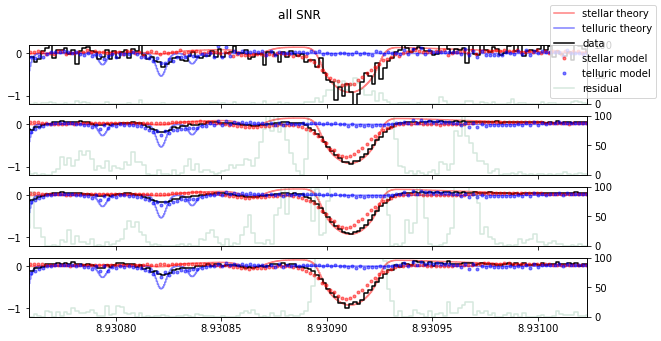

In [83]:
plt_i = 2
xpmin = np.log(7561)
xpmax = np.log(7563)
fig, axes = plt.subplots(plt_inds,figsize=(10,5),sharex=True,sharey=True,facecolor=(1,1,1))

fig.suptitle('all SNR')
for i in range(len(datasets)):       
    axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:])),'r',where='mid',alpha=0.5,label='stellar theory')
    axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]),'b',where='mid',alpha=0.5,label='telluric theory')
    axes[i].step(datasets[i].xs[plt_i,:],datasets[i].ys[plt_i,:],'k',where='mid',label='data')

    axes[i].plot(models[i][0][1].xs-models[i][0][0].p[plt_i],models[i][0][1].p,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')
    axes[i].plot(models[i][1].xs,models[i][1].p,'.b',zorder=2,alpha=0.5,ms=6,label='telluric model')
        
    axes[i].set_xlim(xpmin,xpmax)
    axes[i].set_ylim(-1.2,0.2)
    
    res_ax = axes[i].twinx()
    residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))**2) * datasets[i].yivar[plt_i,:]
    res_ax.step(datasets[i].xs[plt_i,:],residual,'seagreen',where='mid',alpha=0.2,label='residual')
    res_ax.set_xlim(xpmin,xpmax)
    res_ax.set_ylim(0.0,1e2)
# create legend
handles, labels = axes[0].get_legend_handles_labels()
res_handles, res_labels = res_ax.get_legend_handles_labels()
handles.append(*res_handles)
labels.append(*res_labels)
fig.legend(handles, labels)

plt.savefig(os.path.join(outdir,'flux_st_snrs_x{:2.1f}-{:2.1f}.png'.format(xpmin,xpmax)),dpi=300)
plt.show()

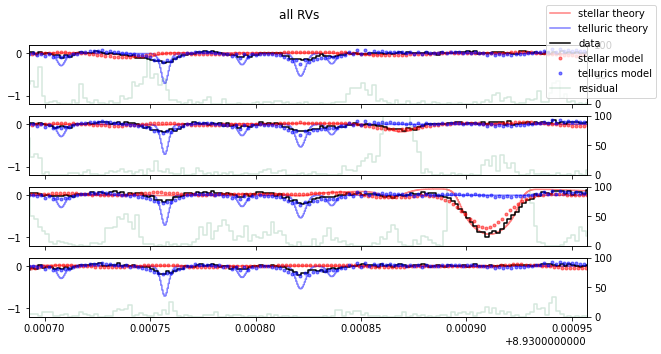

In [84]:
plt_inds = 4
xpmin = np.log(7560.5)
xpmax = np.log(7562.5)
fig, axes = plt.subplots(plt_inds,figsize=(10,5),sharex=True,sharey=True,facecolor=(1,1,1))

fig.suptitle('all RVs')
dataset_i = 1
for j in range(plt_inds):        
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normal_flux(h5_data[dataset_i]['theory']['interpolated']['star']['flux'][j,:])),'r',where='mid',alpha=0.5,label='stellar theory')
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[dataset_i]['theory']['interpolated']['random']['flux'][j,:]),'b',where='mid',alpha=0.5,label='telluric theory')
    axes[j].step(datasets[dataset_i].xs[j,:],datasets[i].ys[j,:],'k',where='mid',label='data')
    
    axes[j].plot(models[dataset_i][0][1].xs-models[dataset_i][0][0].p[j],models[dataset_i][0][1].p,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')
    axes[j].plot(models[dataset_i][1].xs,models[dataset_i][1].p,'.b',zorder=2,alpha=0.5,ms=6,label='tellurics model')
    
    axes[j].set_xlim(xpmin,xpmax)
    axes[j].set_ylim(-1.2,0.2)
    
    res_ax = axes[j].twinx()
    residual = ((datasets[dataset_i].ys[j,:] - models[dataset_i](models[dataset_i].get_parameters(),datasets[dataset_i].xs[j,:],i))**2) * datasets[dataset_i].yivar[j,:]
    res_ax.step(datasets[dataset_i].xs[j,:],residual,'seagreen',where='mid',alpha=0.2,label='residual')
    res_ax.set_xlim(xpmin,xpmax)
    res_ax.set_ylim(0.0,1e2)
# create legend
handles, labels = axes[0].get_legend_handles_labels()
res_handles, res_labels = res_ax.get_legend_handles_labels()
handles.append(*res_handles)
labels.append(*res_labels)
fig.legend(handles, labels)    

plt.savefig(os.path.join(outdir,'flux_st_rvs_x{:2.1f}-{:2.1f}.png'.format(xpmin,xpmax)),dpi=300)
plt.show() 

In [85]:
for i in range(len(datasets)):
#     print(jabble.dataset.velocities(models[i][0].p)[0])
    print(models[i][1].p[:3])

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]


In [86]:
rv[0].to(u.km/u.s), final_vels[0].to(u.km/u.s)

(<Quantity -3003. km / s>, <Quantity -3002.39580619 km / s>)

In [87]:
(final_vels[0] - init_vels[0]).to(u.km/u.s), init_vels[0].to(u.km/u.s), final_vels[0].to(u.km/u.s)

(<Quantity -2.39580619 km / s>,
 <Quantity -3000. km / s>,
 <Quantity -3002.39580619 km / s>)

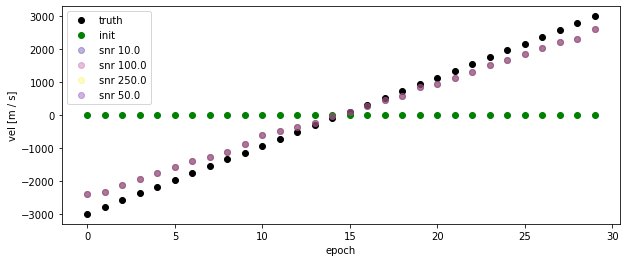

In [91]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='init')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0][0].p)
    
    v_unit = u.m/u.s
    plt.plot((final_vels - init_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.3)
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_st_min_init.png'),dpi=300)
plt.show()

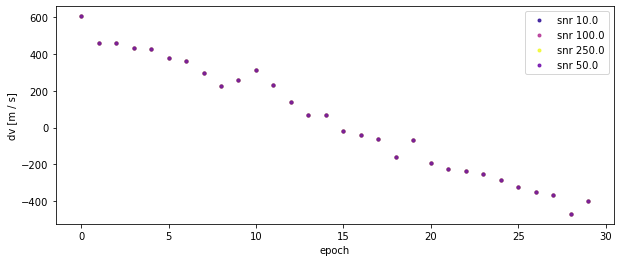

In [94]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s
# plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
# plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='truth')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0][0].p)
    
    v_unit = u.m/u.s
    plt.plot((final_vels - rv).to(v_unit).value,'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8)
    plt.ylabel('dv [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_st_min_rvs.png'),dpi=300)
plt.show()

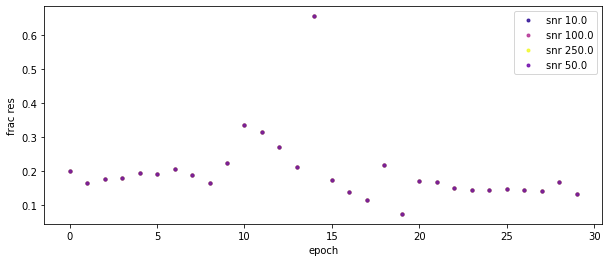

In [90]:
fig = plt.figure(figsize=(10,4))
v_unit = u.m/u.s
# plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
# plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='truth')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0][0].p)
    
    v_unit = u.m/u.s
    plt.plot(abs((final_vels - rv)/rv),'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8)
    plt.ylabel('frac res'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.show()